In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45415,NaN,NaN,International,2020-09-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45416,NaN,NaN,International,2020-09-21,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45417,NaN,NaN,International,2020-09-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


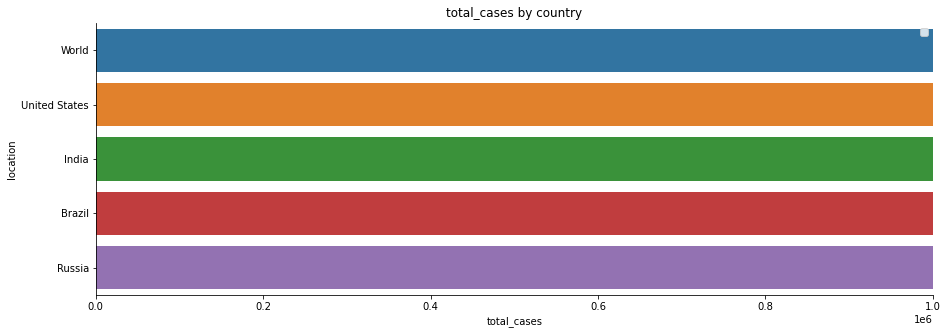

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


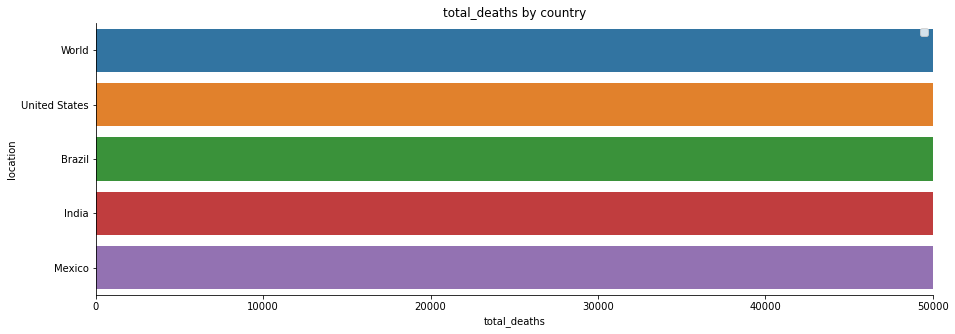

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


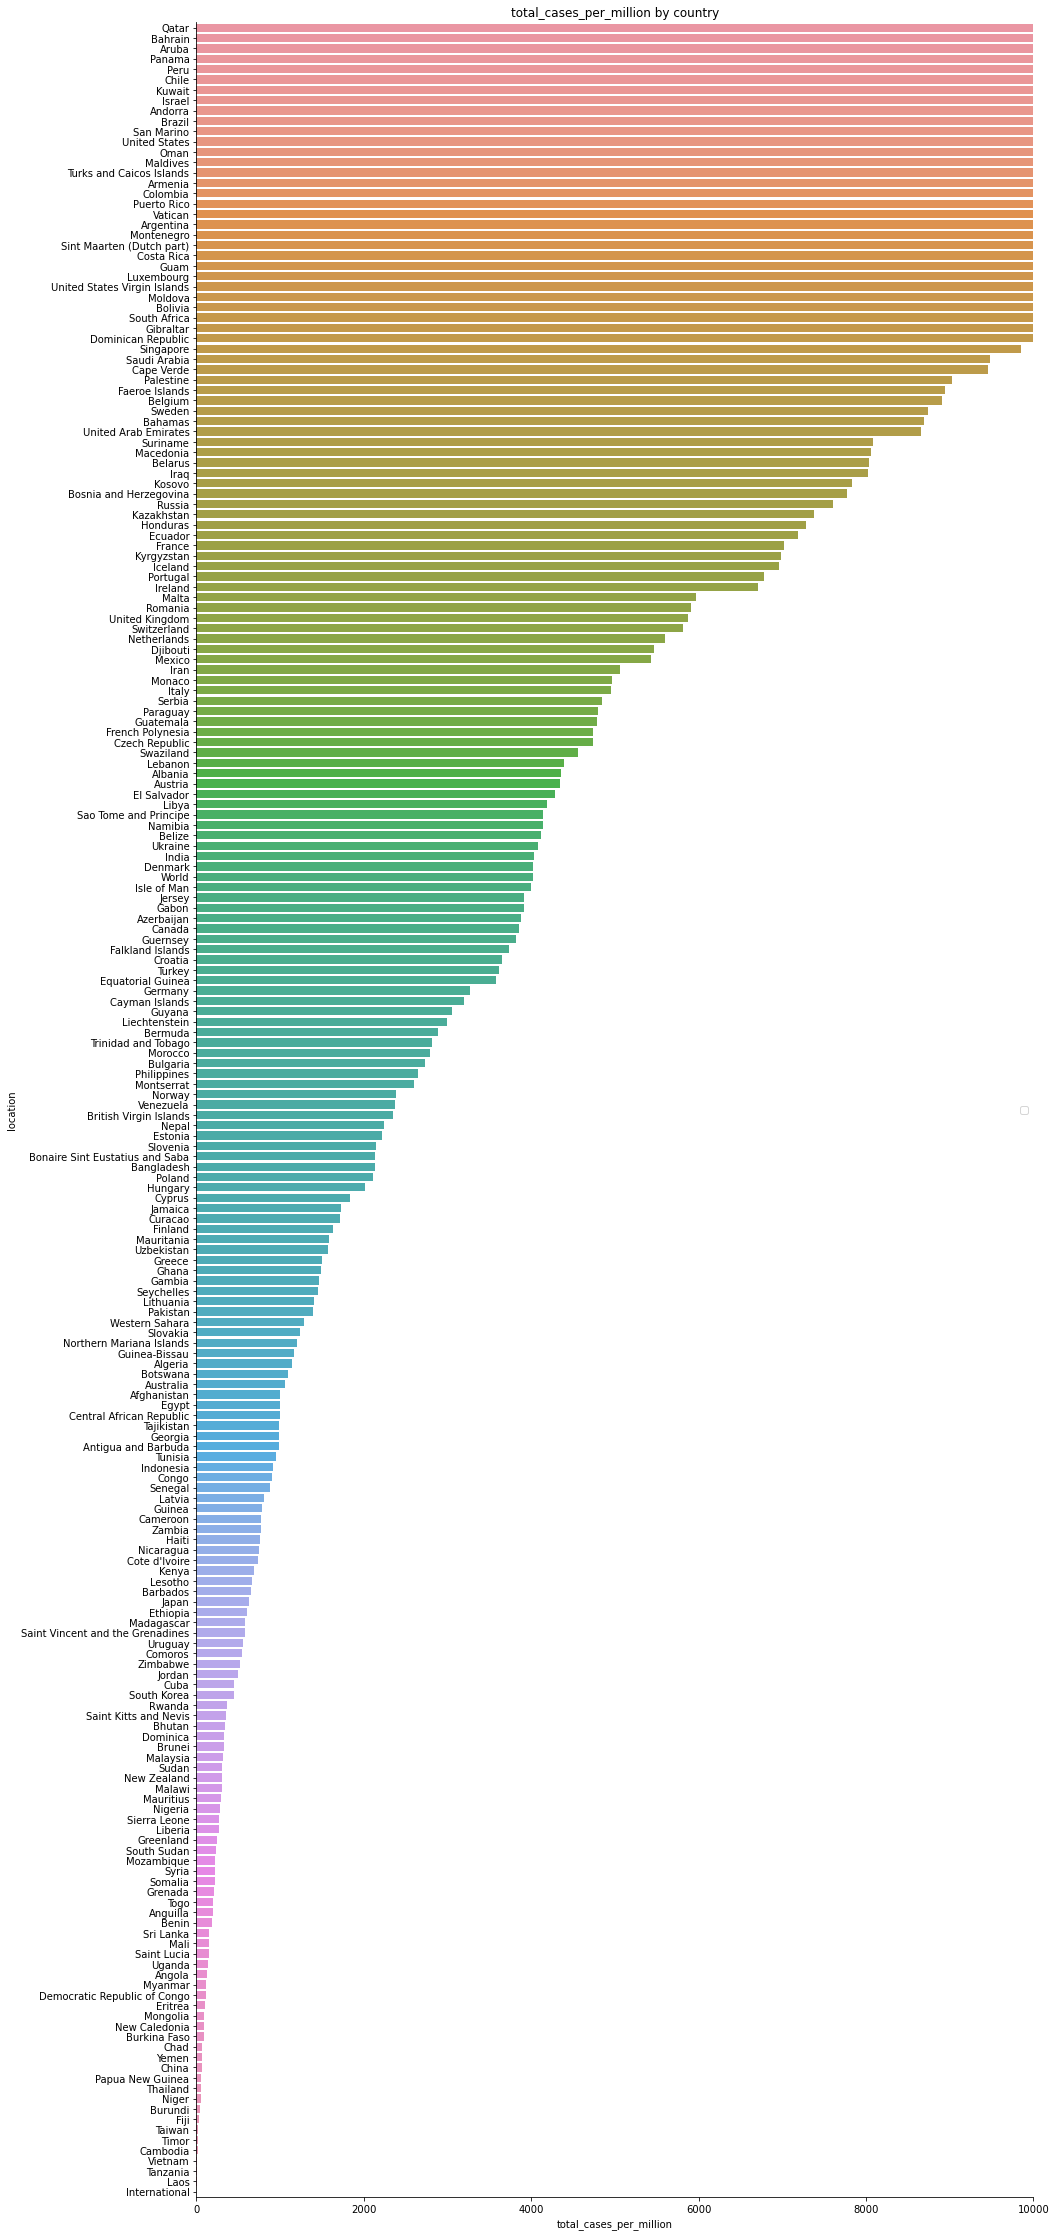

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


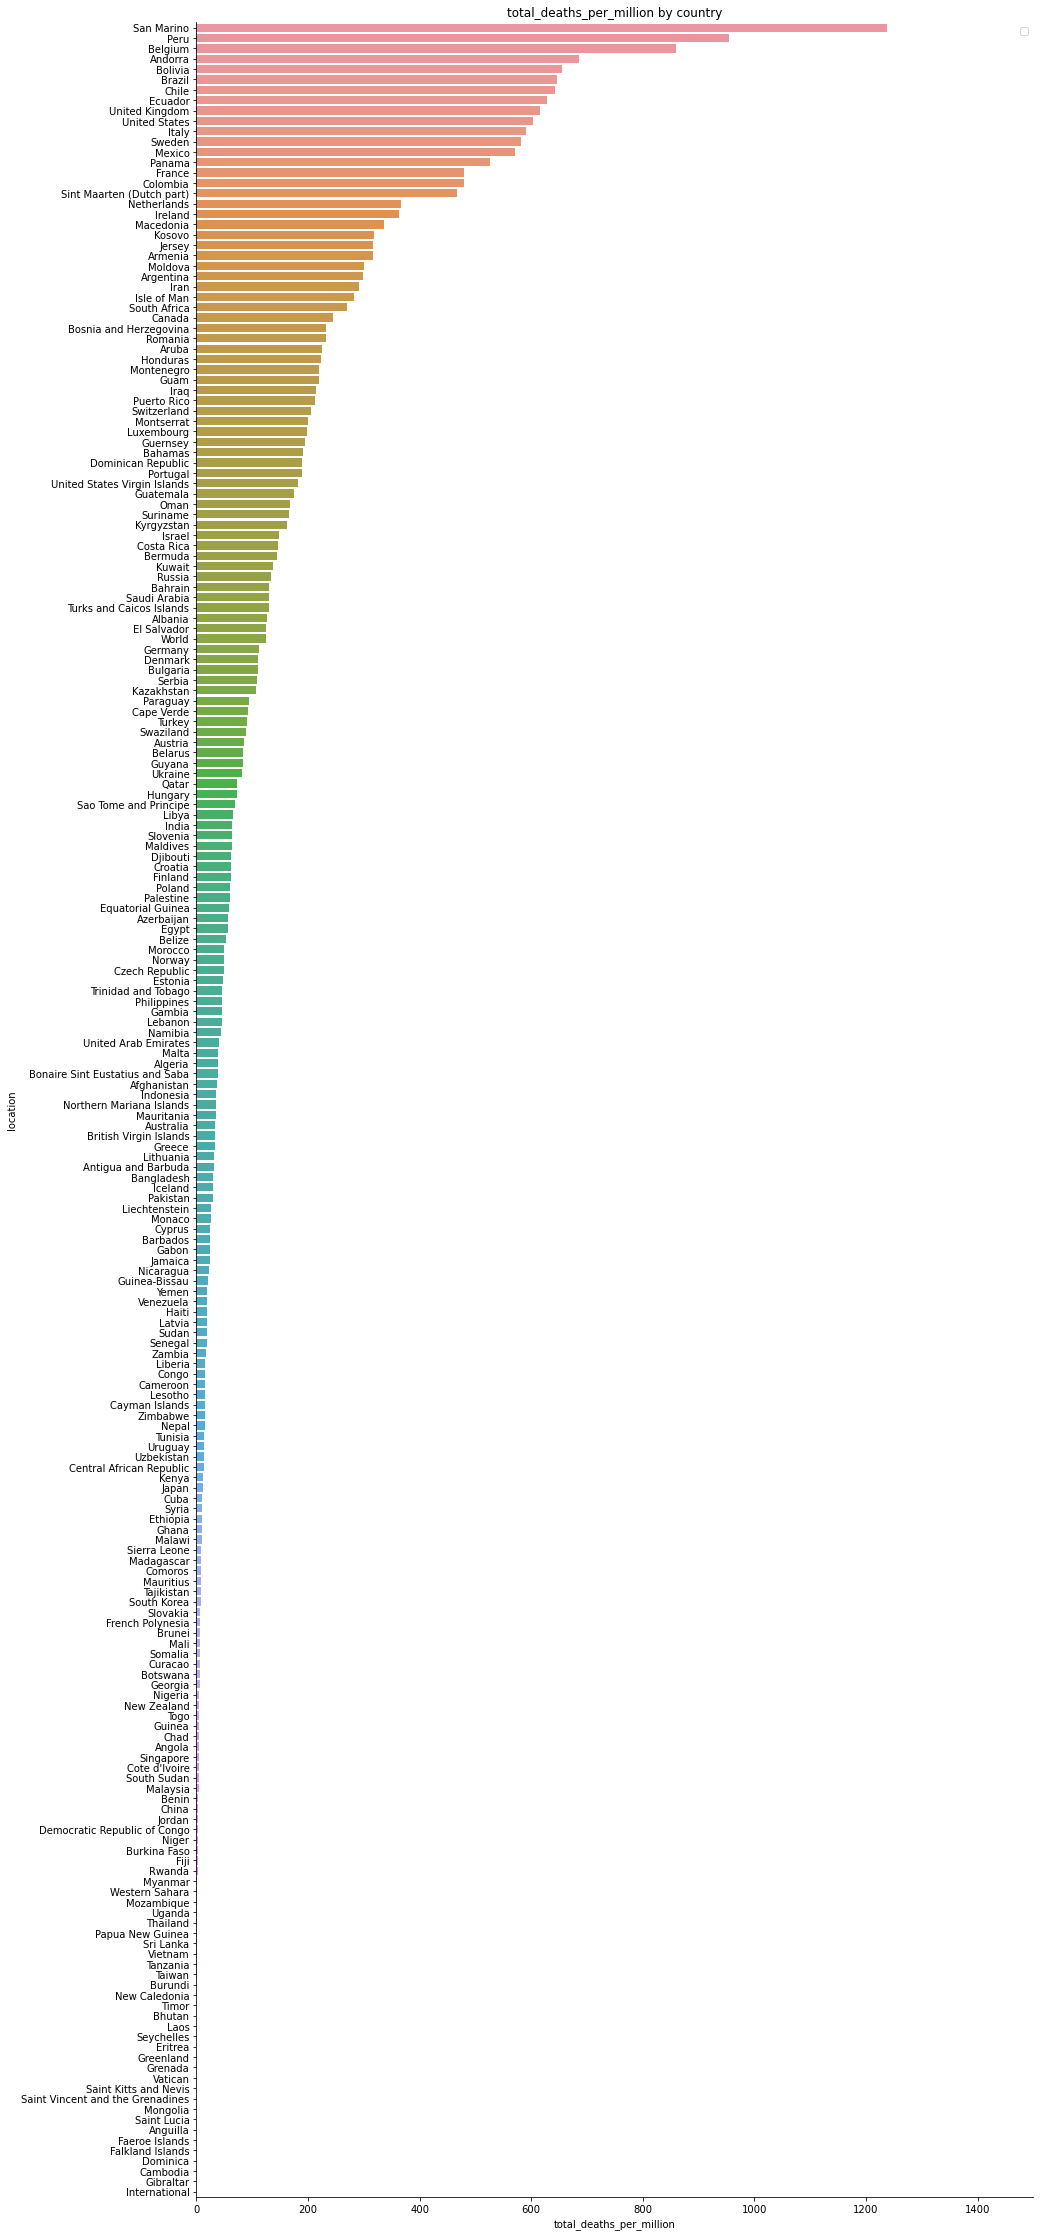

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

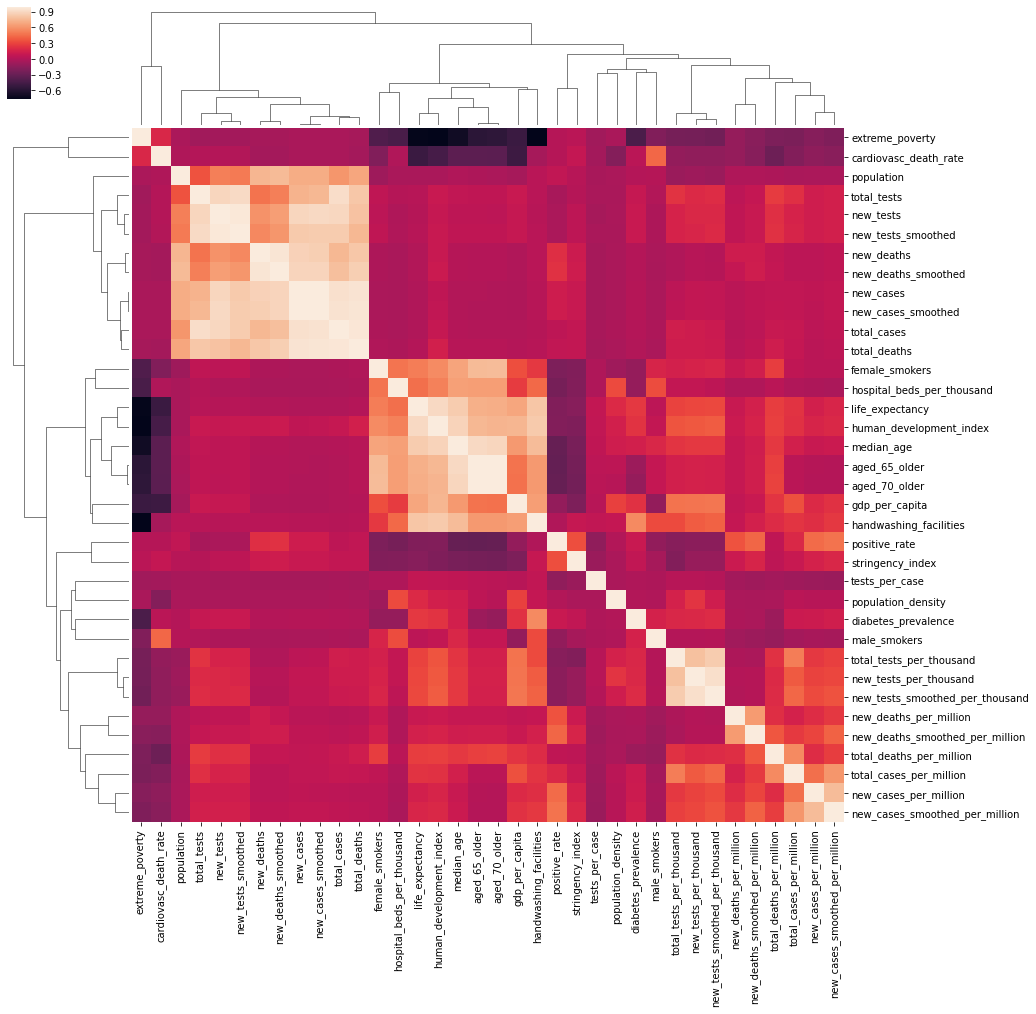

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986112228761904 (+/- 0.0017757713322743983)
Coef :  [1.03170354e+00 8.21286671e-05 8.47400459e-05]
3 Last_days :  [[30838934 31124544 31377058]]
Today :  31377058
Prediction + :  548345
Tomorow :  31925403
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996454388047509 (+/- 0.0001614751857794138)
Coef :  [0.2160943  0.38486368 0.40902859]
3 Last_days :  [[957799 961535 965681]]
Today :  965681
Prediction + :  9655
Tomorow :  975336
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5314593204120585 (+/- 0.6589398841947056)
Coef :  [-0.74183455  0.78542904  0.96138648]
3 Last_days :  [[442194 453763 458061]]
Today :  458061
Prediction + :  10637
Tomorow :  468698
                                     
--------- Total Death -----------------
                                     
R^2: 0.9864237624337439 (+/- 0.007873576262390174)
Coef :  [-0.7462897   0.78773633  0.95751165]
3 Last_days :  [[31274 31285 31338]]
Today :  31338
Prediction + :  27
Tomorow :  31365
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9587547055665459 (+/- 0.04013279946333705)
Coef :  [-0.32989569 -0.01042467  1.33458572]
3 Last_days :  [[90333 90369 90381]]
Today :  90381
Prediction + :  25
Tomorow :  90406
                                     
--------- Total Death -----------------
                                     
R^2: -48.189455348769805 (+/- 69.46500840668244)
Coef :  [-0.07761754  0.01248044  1.05684768]
3 Last_days :  [[4737 4737 4737]]
Today :  4737
Prediction + :  5
Tomorow :  4742
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9436732804650427 (+/- 0.07858646253389547)
Coef :  [-0.81133124  0.89224697  0.91852057]
3 Last_days :  [[296569 298156 299506]]
Today :  299506
Prediction + :  1412
Tomorow :  300918
                                     
--------- Total Death -----------------
                                     
R^2: 0.9397105258905313 (+/- 0.0650733986418213)
Coef :  [-0.81996814  0.89540968  0.92356104]
3 Last_days :  [[35692 35707 35724]]
Today :  35724
Prediction + :  31
Tomorow :  35755
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.343290256681197 (+/- 1.8919732408561174)
Coef :  [-0.26728071  0.17332825  1.10251177]
3 Last_days :  [[640040 640040 671468]]
Today :  671468
Prediction + :  8712
Tomorow :  680180
                                     
--------- Total Death -----------------
                                     
R^2: -0.644541642380062 (+/- 2.0209962430853734)
Coef :  [-0.73032     0.64290158  1.08645357]
3 Last_days :  [[30495 30495 30663]]
Today :  30663
Prediction + :  23
Tomorow :  30686
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9643366051318164 (+/- 0.04865596519848056)
Coef :  [0.12774178 0.43929388 0.44558727]
3 Last_days :  [[6764962 6804814 6857967]]
Today :  6857967
Prediction + :  69527
Tomorow :  6927494
                                     
--------- Total Death -----------------
                                     
R^2: 0.9945860895186831 (+/- 0.00644098636175283)
Coef :  [-0.40019498  0.66879267  0.73409358]
3 Last_days :  [[199258 199509 199881]]
Today :  199881
Prediction + :  986
Tomorow :  200867
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9426602728473474 (+/- 0.08031960147910361)
Coef :  [-0.67503211  0.8260184   0.85000861]
3 Last_days :  [[390358 394257 398625]]
Today :  398625
Prediction + :  2937
Tomorow :  401562
                                     
--------- Total Death -----------------
                                     
R^2: 0.2616060809770108 (+/- 1.0052062111431943)
Coef :  [-0.76418876  0.82995543  0.93347989]
3 Last_days :  [[41759 41777 41788]]
Today :  41788
Prediction + :  46
Tomorow :  41834
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.30015242826901717 (+/- 0.9888625523220277)
Coef :  [-0.77547023  0.8482374   0.92714654]
3 Last_days :  [[271415 272337 274158]]
Today :  274158
Prediction + :  886
Tomorow :  275044
                                     
--------- Total Death -----------------
                                     
R^2: 0.26924713725361016 (+/- 1.0253206333351388)
Coef :  [-0.78366584  0.83885913  0.94400575]
3 Last_days :  [[9386 9386 9396]]
Today :  9396
Prediction + :  5
Tomorow :  9401
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.955534229436164 (+/- 0.06103281657520715)
Coef :  [0.34681928 0.33397806 0.33015489]
3 Last_days :  [[419043 422140 425481]]
Today :  425481
Prediction + :  2939
Tomorow :  428420
                                     
--------- Total Death -----------------
                                     
R^2: 0.9651499995893443 (+/- 0.048618417392049196)
Coef :  [0.14856094 0.43715849 0.42531595]
3 Last_days :  [[24118 24301 24478]]
Today :  24478
Prediction + :  209
Tomorow :  24687
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995265210244204 (+/- 0.00040355909765436463)
Coef :  [-0.63056925  0.8003196   0.82765422]
3 Last_days :  [[301348 302867 304610]]
Today :  304610
Prediction + :  1186
Tomorow :  305796
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990854956201242 (+/- 0.0008680161865049157)
Coef :  [-0.81589561  0.89616782  0.91795324]
3 Last_days :  [[7445 7506 7574]]
Today :  7574
Prediction + :  49
Tomorow :  7623
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9913453560600581 (+/- 0.00897749663646737)
Coef :  [-0.12673822  0.50933057  0.62946998]
3 Last_days :  [[4528240 4544629 4558068]]
Today :  4558068
Prediction + :  60439
Tomorow :  4618507
                                     
--------- Total Death -----------------
                                     
R^2: 0.46544545015058375 (+/- 0.748750444598719)
Coef :  [-0.03556953  0.48627321  0.55951663]
3 Last_days :  [[136532 136895 137272]]
Today :  137272
Prediction + :  1584
Tomorow :  138856
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(31377058, 965681, 31925403, 975336),
 (458061, 31338, 468698, 31365),
 (299506, 35724, 300918, 35755),
 (671468, 30663, 680180, 30686),
 (6857967, 199881, 6927494, 200867),
 (90381, 4737, 90406, 4742),
 (398625, 41788, 401562, 41834),
 (274158, 9396, 275044, 9401),
 (425481, 24478, 428420, 24687),
 (304610, 7574, 305796, 7623),
 (4558068, 137272, 4618507, 138856)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-22,France,468698.0,0.0,31365.0,0.0,0.0,0.0
0,2020-09-22,China,90406.0,0.0,4742.0,0.0,0.0,0.0
0,2020-09-22,Italy,300918.0,0.0,35755.0,0.0,0.0,0.0
0,2020-09-22,Spain,680180.0,0.0,30686.0,0.0,0.0,0.0
0,2020-09-22,United States,6927494.0,0.0,200867.0,0.0,0.0,0.0
0,2020-09-22,World,31925403.0,0.0,975336.0,0.0,0.0,0.0
0,2020-09-22,United Kingdom,401562.0,0.0,41834.0,0.0,0.0,0.0
0,2020-09-22,Germany,275044.0,0.0,9401.0,0.0,0.0,0.0
0,2020-09-22,Iran,428420.0,0.0,24687.0,0.0,0.0,0.0
0,2020-09-22,Turkey,305796.0,0.0,7623.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")